In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# load and examine the data
user_engagement_df = pd.read_csv(r'takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
users_df = pd.read_csv(r'takehome_users.csv', encoding = "ISO-8859-1")
print(users_df.shape)
users_df.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# lets examine the user data to see who is actually using the application
print('There are {} users who have ever used the application.'\
          .format(len(list(user_engagement_df['user_id'].unique()))))
print('There are {} signed up for the application.'\
          .format(len(list(users_df['object_id'].unique()))))

print('There is a discrepancy of {} users.'\
          .format(int(len(list(users_df['object_id'].unique()))) 
                  - int(len(list(user_engagement_df['user_id'].unique())))))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
There is a discrepancy of 3177 users.


In [5]:
# how many people never signed in?
print('There are ', len(users_df[users_df['last_session_creation_time'].isnull()]), 'inactive users.')

There are  3177 inactive users.


There are  3177 inactive users.

So, at this point we have two data sets. The first, we can use to determine if a user is "adopted" the app. Then with the second data set we can use these determined ID's to then produce and evaluate a predictive model. As part of this process we will have to deal with any missing, duplicate, and/or irrelevant data points.
As outlined, in this case an adopted user is any ID that had logged in on at least 3 serarate occasions in a 7 day period.

<h1>Data Wrangling</h1>

In [6]:
# Check for missing data in each of the supplied data sets
print('user_engagement')
print(user_engagement_df.isnull().any())
print("\n")
print('user_engagement')
print(users_df.isnull().any())

user_engagement
time_stamp    False
user_id       False
visited       False
dtype: bool


user_engagement
object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool


In [7]:
# How much missing data do we have e.g. if we drop it how much info is gone?
print(users_df['last_session_creation_time'].isnull().value_counts())
print(users_df['invited_by_user_id'].isnull().value_counts())

False    8823
True     3177
Name: last_session_creation_time, dtype: int64
False    6417
True     5583
Name: invited_by_user_id, dtype: int64


In [8]:
# bring in some datetime
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [9]:
# How many values does 'visited' take?
user_engagement_df['visited'].unique()

array([1], dtype=int64)

In [10]:
# time to add in the adopted user feature so that we can categorize the data
seven_days = datetime.timedelta(7)
adopted_dict = {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user = False
    temp = user_engagement_df[user_engagement_df['user_id'] == user_id]
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue
        this_time = temp.get_value(row[0], 'time_stamp')
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = True
    
    adopted_dict[user_id] = adopted_user

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [12]:
# Create adopted target variable and display dataset again
users_df['adopted'] = False
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [13]:
# Replace adopted target class with correct flags
for row in (users_df[np.logical_not(users_df['last_session_creation_time'].isnull())]).itertuples():
    adopted_value = adopted_dict[users_df.get_value(row[0], 'object_id')]
    users_df.set_value(row[0], 'adopted', adopted_value)
    
print('{:.2f}% of all users who have signed up for the application are considered \'adopted users\'.'\
          .format(len(users_df[users_df['adopted'] == True])/len(users_df)*100))

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


13.80% of all users who have signed up for the application are considered 'adopted users'.


In [14]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [15]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(users_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



In [16]:
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(users_df['last_session_creation_time'].median())


users_df['creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
# day of the week account created
users_df['day_created'] = users_df['creation_time'].apply(lambda x: x.dayofweek)
# hour of the day account created
users_df['hour_created'] = users_df['creation_time'].apply(lambda x: x.hour)
# drop the original column
users_df.drop('creation_time', axis=1, inplace=True)

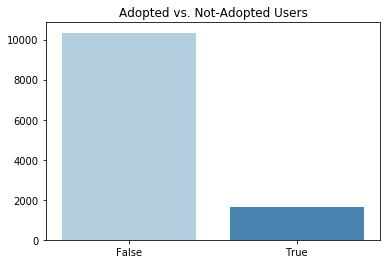

In [17]:
# Take another look at the distribution of the target class
sns.barplot(x = list(users_df['adopted'].value_counts().index), y = users_df['adopted'].value_counts(), palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

In [18]:
users_df.drop(['name', 'email', 'invited_by_user_id', 'object_id'], axis=1, inplace=True)

In [19]:
users_df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,day_created,hour_created
0,GUEST_INVITE,1.398139e+09,1,0,11,False,3,0
1,ORG_INVITE,1.396238e+09,0,0,1,True,3,0
2,ORG_INVITE,1.363735e+09,0,0,94,False,3,0
3,GUEST_INVITE,1.369210e+09,0,0,1,False,3,0
4,GUEST_INVITE,1.358850e+09,0,0,193,False,3,0


In [20]:
# One-hot-encode creation_source
df_encoded = pd.get_dummies(users_df, columns = ['creation_source'])

In [21]:
X = df_encoded.drop('adopted', axis=1)
y = df_encoded['adopted']

In [22]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                           random_state=2007, stratify=users_df['adopted'])


In [23]:
y_train.head()

5655    False
7390    False
3313    False
8560    False
1656    False
Name: adopted, dtype: bool

In [24]:
X.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,day_created,hour_created,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,11,3,0,1,0,0,0,0
1,1.396238e+09,0,0,1,3,0,0,1,0,0,0
2,1.363735e+09,0,0,94,3,0,0,1,0,0,0
3,1.369210e+09,0,0,1,3,0,1,0,0,0,0
4,1.358850e+09,0,0,193,3,0,1,0,0,0,0


In [25]:
classifier = GradientBoostingClassifier(verbose=True)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.7090            0.92s
         2           0.6539            0.93s
         3           0.6143            0.61s
         4           0.5839            0.83s
         5           0.5597            0.66s
         6           0.5399            0.91s
         7           0.5235            0.94s
         8           0.5099            0.90s
         9           0.4975            0.79s
        10           0.4878            0.85s
        20           0.4371            0.56s
        30           0.4208            0.45s
        40           0.4120            0.36s
        50           0.4024            0.30s
        60           0.3945            0.25s
        70           0.3878            0.20s
        80           0.3828            0.13s
        90           0.3799            0.07s
       100           0.3751            0.00s


0.9138888888888889

In [26]:
confusion_matrix(y_test, classifier.predict(X_test))

array([[2986,  117],
       [ 193,  304]], dtype=int64)

In [27]:
classifier.feature_importances_.shape

(11,)

In [28]:
features = pd.Series(classifier.feature_importances_, index=X.columns)

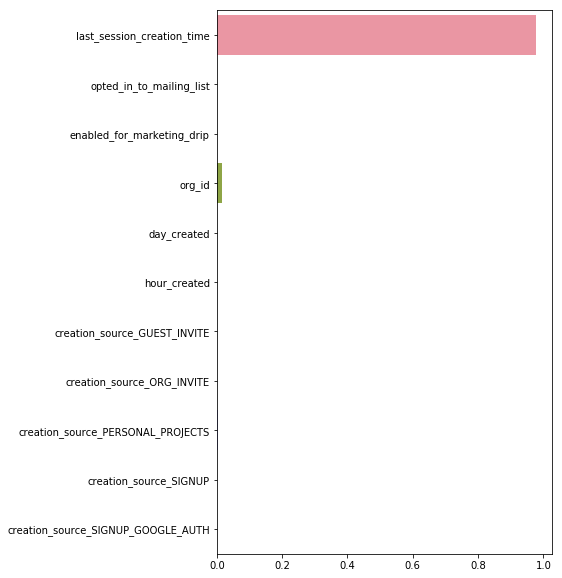

In [29]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_)

Conclusion

From the analysis and the predictive modeling that we have performed above, the results can be summarized as follows:

86% of our userbase are non adopted users. This clearly indicates that there is a lot that can be done to decrease this proportion relative to the number of adopted users. 

last_session_creation_time is the most important feature when it comes to predicting adopted users. It accounts for more than 90% of the importance in our Gradient Boosting Classifier. It is followed by org_id feature.

All the other features have close to zero importance and do not explain the target variable well. 